# Final Model Training and Prediction

Once the best set of variables, the best model, and the optimal hyperparameters for each location have been established in the previous notebook, in this notebook we provide the code to, first, train the model for all locations and compute all the predictions (which generates the groundwater file to be delivered through Taikai), and later, the code to train and obtain the predictions for a single location. 

### Load necessary libraries

In [11]:
import os
import gc
import time
import json
import psutil  # Import for monitoring memory
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  # For plotting

from sklearn.linear_model import Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import make_scorer

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [12]:
# Instruction to show all rows and columns when printing dataframes 
pd.set_option("display.max_columns", None) 
pd.set_option("display.max_rows", None)

### Load necessary data

In [13]:
complete_training_data_df = pd.read_csv("complete_and_fully_processed_data.csv")
complete_training_data_df['id_loc'] = complete_training_data_df['id_loc'].astype(str)

In [14]:
training_data_df = complete_training_data_df.copy()

In [15]:
# Cargar datos de test (observación para cada id_loc)
test_data = pd.read_csv('taikai_test_data_with_exog.csv')
test_data['id_loc'] = test_data['id_loc'].astype(str)

In [16]:
deliverable = pd.read_csv('gw_test_empty.csv')

In [17]:
# Definir los subconjuntos de variables
necessary_vars = complete_training_data_df.columns[list(range(0, 77)) + [136]]
hist_temp_vars = complete_training_data_df.columns[list(range(77, 136))]
geogr_climate_vars = complete_training_data_df.columns[list(range(137, 282))]
soil_demogr_vars = complete_training_data_df.columns[list(range(282, 384))]

# Crear un diccionario que relacione cada vars_set con sus correspondientes columnas
vars_dict = {
    'necessary_vars': necessary_vars,
    'necessary_vars_hist_temp_vars': pd.Index(necessary_vars.tolist() + hist_temp_vars.tolist()),
    'necessary_vars_hist_temp_vars_geogr_climate_vars': pd.Index(necessary_vars.tolist() + hist_temp_vars.tolist() + geogr_climate_vars.tolist()),
    'necessary_vars_hist_temp_vars_geogr_climate_vars_soil_demogr_vars': pd.Index(necessary_vars.tolist() + hist_temp_vars.tolist() + geogr_climate_vars.tolist() + soil_demogr_vars.tolist())
}

## Re-train with full training data and make predictions for all locations

This code pipeline loads the best models and hyperparameters from a JSON file, prepares the training data, and trains models for each location (id_loc). The predictions are made on the test set to be uploaded to the Taikai platform. The code handles memory constraints and dynamically selects the best model and features for each location based on pre-defined configurations.

In [6]:
# Function to prepare the dataset by dropping missing values and resetting the index
def prepare_data(df, lag_columns, step_columns):
    """
    Cleans the dataset by removing missing values and resetting the index.

    Parameters:
    df (pd.DataFrame): The input dataset containing features and targets.
    lag_columns (list): List of lag feature names.
    step_columns (list): List of target step feature names.

    Returns:
    pd.DataFrame: Cleaned dataset with no missing values and reset index.
    """
    df = df.dropna().reset_index(drop=True)
    return df

# Function to calculate the Symmetric Mean Absolute Percentage Error (SMAPE)
def smape(a, f):
    """
    Computes the SMAPE between actual and forecasted values.

    Parameters:
    a (np.array): Actual values.
    f (np.array): Forecasted values.

    Returns:
    float: SMAPE score.
    """
    a, f = np.asarray(a), np.asarray(f)
    mask = np.isfinite(a) & np.isfinite(f) & ((np.abs(a) + np.abs(f)) != 0)
    if np.any(mask):
        return 100 * np.mean(2 * np.abs(f[mask] - a[mask]) / (np.abs(a[mask]) + np.abs(f[mask])))
    return np.nan

# Create a custom scorer based on SMAPE
smape_scorer = make_scorer(smape, greater_is_better=False)

# Function to load best model parameters from a JSON file
def load_best_params(json_file, id_loc):
    """
    Loads the best model, hyperparameters, and variable set for a specific id_loc from a JSON file.

    Parameters:
    json_file (str): Path to the JSON file.
    id_loc (str): Location identifier.

    Returns:
    tuple: Best model name, hyperparameters, and variable set if found, otherwise (None, None, None).
    """
    if os.path.exists(json_file):
        with open(json_file, 'r') as f:
            results = json.load(f)
        if id_loc in results:
            return results[id_loc]['model'], results[id_loc]['hyperparameters'], results[id_loc]['vars_set']
    return None, None, None

# Function to retrieve a model object by its name
def get_model_by_name(model_name):
    """
    Returns the machine learning model object based on the model name.

    Parameters:
    model_name (str): Name of the model.

    Returns:
    model: An instance of the specified model, or None if the model is not found.
    """
    if model_name == 'ridge':
        return Ridge()
    if model_name == 'elasticnet':
        return ElasticNet()
    if model_name == 'lightgbm':
        return LGBMRegressor(verbosity=-1, n_jobs=-1)
    if model_name == 'randomforest':
        return RandomForestRegressor(n_jobs=-1)
    if model_name == 'catboost':
        return CatBoostRegressor(verbose=False, task_type='CPU', thread_count=-1)
    if model_name == 'xgboost':
        return XGBRegressor(tree_method="hist", verbosity=0, n_jobs=-1)
    else:
        return None

# Function to check memory usage and ensure it doesn't exceed the limit
def check_memory_usage(limit_gb=11):
    """
    Monitors the current memory usage and checks if it exceeds the specified limit.

    Parameters:
    limit_gb (int): Memory limit in gigabytes (GB).

    Returns:
    bool: True if memory usage exceeds the limit, otherwise False.
    """
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()
    memory_used_gb = memory_info.rss / (1024 ** 3)  # Convert memory usage to GB
    return memory_used_gb > limit_gb

# Function to train and evaluate a model with pre-loaded parameters using cross-validation
def train_and_evaluate_model_with_params(model_name, model, best_params, X_train, y_train, n_folds=7, memory_limit_gb=11):
    """
    Trains a model using the best hyperparameters loaded from the JSON file and performs cross-validation.

    Parameters:
    model_name (str): Name of the model being trained.
    model: The machine learning model object.
    best_params (dict): The best hyperparameters for the model.
    X_train (pd.DataFrame): Training feature set.
    y_train (pd.DataFrame): Training target set.
    n_folds (int): Number of folds for cross-validation.
    memory_limit_gb (int): Memory limit in gigabytes.

    Returns:
    tuple: Trained model and a placeholder SMAPE CV score.
    """
    cv = KFold(n_splits=n_folds, random_state=42, shuffle=True)
    
    if model_name in ['ridge', 'elasticnet', 'lightgbm', 'randomforest']:
        smape_cv_scores = []
        multi_model = MultiOutputRegressor(model.set_params(**best_params))
        
        if check_memory_usage(memory_limit_gb):
            print(f"Memory limit exceeded for {model_name}. Skipping iteration.")
            return None, np.inf
            
        multi_model.fit(X_train, y_train)
        return multi_model, -1
        
    else:
        model.set_params(**best_params)
        
        try:
            if check_memory_usage(memory_limit_gb):
                print(f"Memory limit exceeded for {model_name}. Skipping iteration.")
                return None, np.inf
            
            model.fit(X_train, y_train)
        except MemoryError:
            print(f"Memory limit exceeded for {model_name}. Skipping iteration.")
            return None, np.inf
        
        return model, -1  # Placeholder for SMAPE CV

# Main function to train models for all id_loc using hyperparameters from a JSON file
def train_model_for_all_id_locs_using_json(training_data_df, lag_columns, step_columns, json_file, n_folds=7, memory_limit_gb=11, deliverable=None):
    """
    Trains and predicts for each id_loc using the best models and hyperparameters loaded from a JSON file.

    Parameters:
    training_data_df (pd.DataFrame): Training dataset.
    lag_columns (list): List of lag features.
    step_columns (list): List of step features (target).
    json_file (str): Path to the JSON file containing the best models and hyperparameters.
    n_folds (int): Number of folds for cross-validation.
    memory_limit_gb (int): Memory limit in gigabytes.
    deliverable (dict): Dictionary to store the predictions.

    Returns:
    None
    """
    unique_id_loc = training_data_df['id_loc'].unique()
    total_locs = len(unique_id_loc)
    training_data_df = prepare_data(training_data_df, lag_columns, step_columns)

    for idx, id_loc in enumerate(unique_id_loc, 1):
        print(f"\nTraining model for location {id_loc} (Iteration {idx} of {total_locs})")
        
        model_name, best_params, vars_set = load_best_params(json_file, id_loc)

        if model_name is None or best_params is None:
            print(f"No hyperparameters found for {id_loc}. Skipping...")
            continue
            
        feature_columns = vars_dict[vars_set]
        loc_data = training_data_df[training_data_df['id_loc'] == id_loc][feature_columns]
        X = loc_data.drop(step_columns + ['id_loc', 'Zone'], axis=1)
        y = loc_data[step_columns]

        model = get_model_by_name(model_name)
        best_model, smape_cv = train_and_evaluate_model_with_params(model_name, model, best_params, X, y, n_folds, memory_limit_gb)

        if best_model is None:
            print(f"Skipping training for {model_name} in id_loc {id_loc} due to memory issues.")
            continue

        X_test = test_data[test_data['id_loc'] == id_loc][X.columns]
        y_pred_test = best_model.predict(X_test)

        deliverable[id_loc] = y_pred_test.flatten()

        del X, y, X_test, best_model, y_pred_test
        gc.collect()

    print(f"\nCompleted training for all models.")

# Function to train models based on a JSON file
def train_models_for_each_model_using_json(training_data_df, lag_columns, step_columns, json_file, n_folds=7, memory_limit_gb=11, deliverable=None):
    """
    Trains models for each id_loc by reading hyperparameters and model definitions from a JSON file.

    Parameters:
    training_data_df (pd.DataFrame): Training dataset.
    lag_columns (list): List of lag features.
    step_columns (list): List of step features (target).
    json_file (str): Path to the JSON file containing the best models and hyperparameters.
    n_folds (int): Number of folds for cross-validation.
    memory_limit_gb (int): Memory limit in gigabytes.
    deliverable (dict): Dictionary to store the predictions.

    Returns:
    None
    """
    print(f"\n***** Starting model training *****")
    train_model_for_all_id_locs_using_json(training_data_df, lag_columns, step_columns, json_file, n_folds, memory_limit_gb, deliverable)

# Configure lag and step columns
lag_columns = [f'lag_{i}' for i in range(50, 0, -1)]
step_columns = [f'step_{i}' for i in range(1, 27)]

# Define the JSON file containing the best models and hyperparameters
json_file = 'best_models_combined.json'

# Call the main pipeline to start training
train_models_for_each_model_using_json(training_data_df, lag_columns, step_columns, json_file, deliverable=deliverable)


***** Iniciando entrenamiento de modelos *****

Training model for location 324095 (Iteración 1 de 487)

Training model for location 323295 (Iteración 2 de 487)

Training model for location 323154 (Iteración 3 de 487)

Training model for location 304535 (Iteración 4 de 487)

Training model for location 326934 (Iteración 5 de 487)

Training model for location 307397 (Iteración 6 de 487)

Training model for location 319053 (Iteración 7 de 487)

Training model for location 303727 (Iteración 8 de 487)

Training model for location 319699 (Iteración 9 de 487)

Training model for location 304352 (Iteración 10 de 487)

Training model for location 328419 (Iteración 11 de 487)

Training model for location 328724 (Iteración 12 de 487)

Training model for location 318824 (Iteración 13 de 487)

Training model for location 329789 (Iteración 14 de 487)

Training model for location 313700 (Iteración 15 de 487)

Training model for location 309617 (Iteración 16 de 487)

Training model for location 3018

In [7]:
deliverable.tail()

,date,324095,323295,323154,304535,326934,307397,319053,303727,319699,304352,328419,328724,318824,329789,313700,309617,301838,306928,330928,325019,325894,308585,321984,316505,309211,327031,320754,329078,324038,308668,304410,330381,305060,310029,309823,318444,322990,313064,328690,314104,307843,323550,322255,377887,316661,300665,325928,301440,301812,321471,331330,307793,302307,315689,321778,304428,300616,322610,328815,321448,322115,304071,323204,313833,304741,301937,327551,330480,314534,302992,327809,332783,312504,319236,324020,328401,319947,329813,309427,302380,323055,300269,317230,327171,312918,323253,316265,312900,308924,323766,325142,325969,323428,310268,319889,309906,314161,319772,331272,321430,313239,311951,321646,302240,301846,300996,312736,319764,305292,334052,311639,323709,330456,323097,330738,308783,313569,318345,328773,329037,304675,326595,312611,327536,375113,330811,325134,329649,302901,317446,303909,315960,324327,328211,317396,313643,319202,309021,326975,314641,311548,327619,323675,311944,307124,331082,318873,313668,307082,379313,313460,326843,310862,331116,327411,304733,315671,322578,323121,376715,376608,313544,327114,302588,319921,304923,327239,328260,315168,331058,325274,304170,323774,309054,323618,305268,325738,312165,329995,332569,323410,376517,317461,331439,328443,307520,300822,315390,318485,320747,303917,312660,330027,328021,311266,329573,301309,330852,330910,300236,375923,311381,303263,314021,311845,313817,304956,329268,322925,309872,321752,315580,309625,312447,300111,309609,300400,308247,329144,318584,310672,328435,300970,301572,330274,307157,374314,321950,376657,330829,328666,376954,314054,324434,303503,321836,321554,328104,330803,322396,326868,301127,304691,374967,374074,309005,307298,304063,331223,304600,329169,310995,309419,301648,310607,325167,309948,305102,346056,322156,307769,316612,331124,327437,319830,319962,315853,329847,331397,303016,328864,330001,327163,309641,314294,323832,303982,374678,322313,306613,321992,333088,300780,331298,310532,316356,317594,322479,328302,307355,303248,338616,300384,317487,300137,305540,305706,305714,305813,305821,305854,305862,305896,305920,305946,305953,306001,306092,306183,306266,306274,306399,306415,306456,306522,313304,313338,313387,345181,306043,305524,305755,305904,305938,305987,305995,306167,306209,305672,306084,316026,316000,316083,316091,316174,319418,319426,319434,319541,319442,326082,326108,326132,326140,326074,326181,326199,326223,326231,326264,326249,326280,326298,326306,326355,326371,326389,326413,326439,326447,326462,335067,335091,326504,335018,335026,335208,335141,335174,335182,335117,335109,335216,335299,335315,335323,335331,335349,335497,335372,335414,335422,335430,335448,335455,335471,335521,335539,335547,335554,335562,335570,335588,335620,335638,335646,335653,335661,335679,335695,335778,335810,335844,335851,335869,335596,335612,335604,335877,335885,335893,335927,335729,335737,335828,335836,335901,335943,335968,335976,335984,335992,336008,345017,345025,345041,345058,345066,345108,345116,345124,345132,345215,345173,345140,345157,345165,345199,345207,345249,345256,345264,345272,345298,345314,345348,345405,345397,345223,345322,345330,345280,345363,345371,345389,345421,345520,345538,345546,345512,345496,345504,345553,345561,345579,345587,345595,345413,345439,345447,345454,345462,345470,345488,345603,345660,345355,345629,345710,345744,345736,345694,345728,345645,345652,345678,345686
21,2023-10-01,249.197113,249.459015,246.819901,140.593384,242.909404,260.428647,207.338974,174.510071,154.348083,173.612656,396.176392,631.487993,364.700421,277.744965,150.173660,494.437866,200.835281,255.950845,595.845122,410.188651,269.338684,232.915681,525.542641,244.791382,227.589405,178.340258,430.4805,238.112961,249.793655,234.782391,173.847198,560.316789,153.0540,659.148682,489.839697,256.245850,225.414130,152.690200,209.509650,199.354080,267.341614,258.942200,396.623463,248.815048,229.505547,292.673737,309.526989,321.073002,204.480331,473.784699,244.271683,292.284806,236

### Save predictions of Task 1

In [8]:
deliverable.to_csv('deliverable_predictions_task1.csv', index = False)

## Re-train with full training data and make predictions for one single location

In [18]:
# Function to prepare the dataset by dropping missing values and resetting the index
def prepare_data(df, lag_columns, step_columns):
    """
    Cleans the dataset by removing missing values and resetting the index.

    Parameters:
    df (pd.DataFrame): The input dataset containing features and targets.
    lag_columns (list): List of lag feature names.
    step_columns (list): List of target step feature names.

    Returns:
    pd.DataFrame: Cleaned dataset with no missing values and reset index.
    """
    df = df.dropna().reset_index(drop=True)
    return df

# Function to calculate the Symmetric Mean Absolute Percentage Error (SMAPE)
def smape(a, f):
    """
    Computes the SMAPE between actual and forecasted values.

    Parameters:
    a (np.array): Actual values.
    f (np.array): Forecasted values.

    Returns:
    float: SMAPE score.
    """
    a, f = np.asarray(a), np.asarray(f)
    mask = np.isfinite(a) & np.isfinite(f) & ((np.abs(a) + np.abs(f)) != 0)
    if np.any(mask):
        return 100 * np.mean(2 * np.abs(f[mask] - a[mask]) / (np.abs(a[mask]) + np.abs(f[mask])))
    return np.nan

# Create a custom scorer based on SMAPE
smape_scorer = make_scorer(smape, greater_is_better=False)

# Function to load the best model parameters from a JSON file
def load_best_params(json_file, id_loc):
    """
    Loads the best model, hyperparameters, and variable set for a specific id_loc from a JSON file.

    Parameters:
    json_file (str): Path to the JSON file.
    id_loc (str): Location identifier.

    Returns:
    tuple: Best model name, hyperparameters, and variable set if found, otherwise (None, None, None).
    """
    if os.path.exists(json_file):
        with open(json_file, 'r') as f:
            results = json.load(f)
        if id_loc in results:
            return results[id_loc]['model'], results[id_loc]['hyperparameters'], results[id_loc]['vars_set']
    return None, None, None

# Function to retrieve a model object by its name
def get_model_by_name(model_name):
    """
    Returns the machine learning model object based on the model name.

    Parameters:
    model_name (str): Name of the model.

    Returns:
    model: An instance of the specified model, or None if the model is not found.
    """
    if model_name == 'ridge':
        return Ridge()
    if model_name == 'elasticnet':
        return ElasticNet()
    if model_name == 'lightgbm':
        return LGBMRegressor(verbosity=-1, n_jobs=-1)
    if model_name == 'randomforest':
        return RandomForestRegressor(n_jobs=-1)
    if model_name == 'catboost':
        return CatBoostRegressor(verbose=False, task_type='CPU', thread_count=-1)
    if model_name == 'xgboost':
        return XGBRegressor(tree_method="hist", verbosity=0, n_jobs=-1)
    else:
        return None

# Function to check memory usage and ensure it doesn't exceed the limit
def check_memory_usage(limit_gb=11):
    """
    Monitors the current memory usage and checks if it exceeds the specified limit.

    Parameters:
    limit_gb (int): Memory limit in gigabytes (GB).

    Returns:
    bool: True if memory usage exceeds the limit, otherwise False.
    """
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()
    memory_used_gb = memory_info.rss / (1024 ** 3)  # Convert memory usage to GB
    return memory_used_gb > limit_gb

# Function to train and evaluate a model using pre-loaded parameters with cross-validation
def train_and_evaluate_model_with_params(model_name, model, best_params, X_train, y_train, n_folds=7, memory_limit_gb=11):
    """
    Trains a model using the best hyperparameters loaded from the JSON file and performs cross-validation.

    Parameters:
    model_name (str): Name of the model being trained.
    model: The machine learning model object.
    best_params (dict): The best hyperparameters for the model.
    X_train (pd.DataFrame): Training feature set.
    y_train (pd.DataFrame): Training target set.
    n_folds (int): Number of folds for cross-validation.
    memory_limit_gb (int): Memory limit in gigabytes.

    Returns:
    tuple: Trained model and a placeholder SMAPE CV score.
    """
    cv = KFold(n_splits=n_folds, random_state=42, shuffle=True)
    
    if model_name in ['ridge', 'elasticnet', 'lightgbm', 'randomforest']:
        multi_model = MultiOutputRegressor(model.set_params(**best_params))
        
        if check_memory_usage(memory_limit_gb):
            print(f"Memory limit exceeded for {model_name}. Skipping iteration.")
            return None, np.inf
            
        multi_model.fit(X_train, y_train)
        return multi_model, -1
        
    else:
        model.set_params(**best_params)
        
        try:
            if check_memory_usage(memory_limit_gb):
                print(f"Memory limit exceeded for {model_name}. Skipping iteration.")
                return None, np.inf
            
            model.fit(X_train, y_train)
        except MemoryError:
            print(f"Memory limit exceeded for {model_name}. Skipping iteration.")
            return None, np.inf
        
        return model, -1  # Placeholder for SMAPE CV

# Function to train and predict for a specific id_loc
def train_and_predict_for_id_loc(training_data_df, lag_columns, step_columns, json_file, id_loc, n_folds=7, memory_limit_gb=11):
    """
    Trains a model and generates predictions for a specific location (id_loc) using parameters from a JSON file.

    Parameters:
    training_data_df (pd.DataFrame): The dataset containing features and targets.
    lag_columns (list): List of lag feature names.
    step_columns (list): List of target step feature names.
    json_file (str): Path to the JSON file with the best models and hyperparameters.
    id_loc (str): Location identifier for which the model is trained.
    n_folds (int): Number of folds for cross-validation.
    memory_limit_gb (int): Memory limit in gigabytes (GB).

    Returns:
    tuple: The trained model and predictions for the blind test set.
    """
    # Prepare the dataset
    training_data_df = prepare_data(training_data_df, lag_columns, step_columns)

    # Load the best parameters from the JSON file for the specific id_loc
    model_name, best_params, vars_set = load_best_params(json_file, id_loc)

    if model_name is None or best_params is None:
        print(f"No hyperparameters found for {id_loc}.")
        return None, None

    # Define the feature columns based on the variable set
    feature_columns = vars_dict[vars_set]

    # Filter the data for the specific id_loc
    loc_data = training_data_df[training_data_df['id_loc'] == id_loc][feature_columns]
    X = loc_data.drop(step_columns + ['id_loc', 'Zone'], axis=1)
    y = loc_data[step_columns]

    # Train and evaluate the model
    model = get_model_by_name(model_name)
    best_model, smape_cv = train_and_evaluate_model_with_params(model_name, model, best_params, X, y, n_folds, memory_limit_gb)

    if best_model is None:
        print(f"Memory issues during training for {id_loc}.")
        return None, None

    # Predict on the blind test set
    X_test = test_data[test_data['id_loc'] == id_loc][X.columns]
    y_pred_test = best_model.predict(X_test)

    # Plot the lags and predicted steps
    lag_values = X_test[lag_columns].values.flatten()
    step_values = y_pred_test.flatten()

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 51), lag_values, label='Lags (lag_50 to lag_1)', color='blue')
    plt.plot(range(51, 77), step_values, label='Predicted Steps (step_1 to step_26)', color='orange')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'Time series for id_loc {id_loc}')
    plt.legend()
    plt.show()

    return best_model, y_pred_test

# Configure lag and step columns
lag_columns = [f'lag_{i}' for i in range(50, 0, -1)]
step_columns = [f'step_{i}' for i in range(1, 27)]

# Define the JSON file that contains the best models and hyperparameters
json_file = 'best_models_combined.json'

## Train model for specific location and get predictions

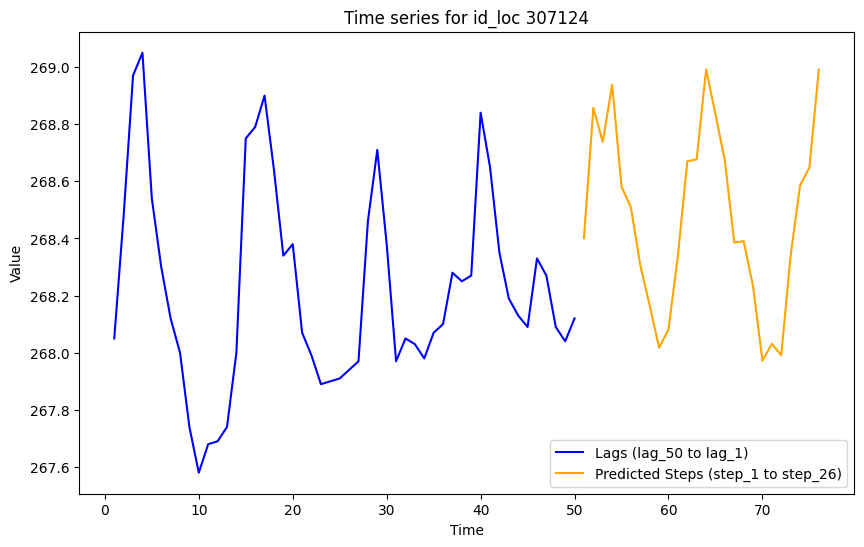

In [41]:
id_loc = '307124'  # Specify the desired id_loc
trained_model, predictions = train_and_predict_for_id_loc(training_data_df, lag_columns, step_columns, json_file, id_loc)

In [42]:
trained_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

In [44]:
predictions

array([[268.40094, 268.85715, 268.73785, 268.93808, 268.58188, 268.50806,
        268.30588, 268.16486, 268.01727, 268.08163, 268.3395 , 268.67004,
        268.67682, 268.99173, 268.83417, 268.6718 , 268.38562, 268.39075,
        268.23203, 267.97144, 268.03104, 267.99124, 268.34006, 268.5846 ,
        268.64865, 268.99084]], dtype=float32)